# Importando Bibliotecas:

In [1]:
import pandas as pd  # Manipulação de dados tabulares (DataFrames)
import numpy as np  # Manipulação eficiente de arrays e operações matemáticas
import os  # Manipulação de sistema de arquivos
import cv2
from google.colab.patches import cv2_imshow

# import glob

import matplotlib.pyplot as plt  # Criação de gráficos e visualizações

# from matplotlib.collections import LineCollection

import seaborn as sns
# import plotly.express as px

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# # Rodrigo:
# !cp "/content/drive/MyDrive/Cod_open/artemis.py" .

# Gustavo:
!cp "/content/drive/MyDrive/PPGNeuro/Cod_open/artemis.py" .

import artemis as lua

# Funções:

## Globais:

### Extração do nome da amostra no resgistro:

In [4]:
def extrair_nome_arquivo(caminho: str) -> str:
  """
  Extrai o nome do arquivo (sem a extensão) de um caminho de arquivo fornecido.

  Args:
      caminho (str): O caminho completo do arquivo.

  Returns:
      str: O nome do arquivo sem a extensão.
  """
  import os  # Importa o módulo os, que fornece funções para interagir com o sistema operacional.

  # Obtém o nome do arquivo com a extensão a partir do caminho completo.
  nome_arquivo_com_extensao = os.path.basename(caminho)

  # Separa o nome do arquivo da sua extensão.
  nome_arquivo_sem_extensao = os.path.splitext(nome_arquivo_com_extensao)[0]

  # Divide o nome do arquivo na parte anterior a "DLC".
  id_part = nome_arquivo_sem_extensao.split("DLC")

  # Se houver uma parte antes de "DLC", essa será usada como o ID do arquivo.
  # Caso contrário, o nome do arquivo sem a extensão será usado como o ID do arquivo.
  arquive_id = id_part[0] if id_part else nome_arquivo_sem_extensao

  # Retorna o ID do arquivo.
  return arquive_id

## Referentes aos videos:

### Extração dos dados intrisicos ao video:

In [5]:
def obter_dados_video(caminho: str):
  """
  Obtém informações detalhadas sobre um vídeo a partir de seu caminho.

  Args:
    caminho (str): O caminho completo do arquivo de vídeo.

  Returns:
    tuple: Contém o primeiro frame do vídeo, altura, largura, FPS, número total de frames e duração em minutos.
    Retorna (None, None, None, None, None, None) se ocorrer algum erro.
  """
  import cv2  # Importa a biblioteca OpenCV para processamento de vídeo.

  # Abre o arquivo de vídeo
  video_cap = cv2.VideoCapture(caminho)

  # Verifica se o vídeo foi aberto com sucesso
  if not video_cap.isOpened():
    print(f"Erro ao abrir o arquivo: {caminho}")
    return None, None, None, None, None, None

  # Lê o primeiro frame do vídeo
  ret, frame = video_cap.read()
  if not ret:
    print(f"Erro ao ler o primeiro frame do vídeo: {caminho}")
    video_cap.release()
    return None, None, None, None, None, None

  # Obtém as dimensões do frame (altura e largura)
  altura, largura, _ = frame.shape

  # Obtém a taxa de frames por segundo (FPS) do vídeo
  fps = video_cap.get(cv2.CAP_PROP_FPS)

  # Obtém o número total de frames do vídeo
  total_frames = int(video_cap.get(cv2.CAP_PROP_FRAME_COUNT))

  # Calcula a duração do vídeo em segundos e depois em minutos
  duration_seconds = total_frames / fps
  duration_min = duration_seconds / 60

  # Libera o recurso de captura de vídeo
  video_cap.release()

  # Retorna as informações do vídeo
  return frame, altura, largura, fps, total_frames, duration_min

### Estrutura dos dados dos videos:

In [6]:
def processar_videos(diretorio: str):
  """
  Processa todos os vídeos .mp4 em um diretório e retorna um DataFrame com os dados.

  Args:
    diretorio (str): O caminho do diretório contendo os vídeos .mp4.

  Returns:
    tuple: DataFrame com os dados dos vídeos e uma lista dos primeiros frames.
  """
  import os  # Importa o módulo os para interagir com o sistema operacional.
  import glob  # Importa o módulo glob para encontrar todos os caminhos correspondentes a um padrão específico.
  import cv2  # Importa a biblioteca OpenCV para processamento de vídeo.
  import pandas as pd  # Importa a biblioteca pandas para manipulação de dados.

  primeiros_frames = []  # Lista para armazenar os primeiros frames dos vídeos.
  dados_image_list = []  # Lista para armazenar os dados dos vídeos.

  # Obtém todos os arquivos .mp4 no diretório especificado.
  arquivos_mp4 = glob.glob(os.path.join(diretorio, "*.mp4"))

  # Verifica se o diretório para salvar os frames existe; se não, cria-o.
  caminho_primeiro_frame = os.path.join(diretorio, 'primeiro_frame')
  if not os.path.exists(caminho_primeiro_frame):
    os.makedirs(caminho_primeiro_frame)

  # Processa cada arquivo .mp4 encontrado.
  for arquivo in arquivos_mp4:
    frame, altura, largura, fps, total_frames, duration_min = obter_dados_video(arquivo)

    if frame is not None:
      # Extrai o ID do vídeo a partir do nome do arquivo.
      id = extrair_nome_arquivo(arquivo)

      # Adiciona os dados do vídeo à lista de dados.
      dados_image_list.append({
        'id_video': id,
        'fps': fps,
        'altura': altura,
        'largura': largura,
        'qtd_frames': total_frames,
        'duration_sec': duration_min * 60,
        'duration_min': duration_min,
        'addres_video': arquivo
      })

      # Adiciona o primeiro frame à lista de frames.
      primeiros_frames.append(frame)

      # Especifica o caminho completo onde a imagem será salva.
      caminho_destino = os.path.join(caminho_primeiro_frame, f'{id}.jpg')

      # Usa a função imwrite do OpenCV para salvar a imagem.
      try:
        cv2.imwrite(caminho_destino, frame)
      except Exception as e:
        print(f"Erro ao salvar a imagem {caminho_destino}: {e}")

    else:
      print(f"O frame do arquivo {arquivo} possui um erro.")

  # Cria um DataFrame com os dados dos vídeos.
  dados_image = pd.DataFrame(dados_image_list)

  # Retorna o DataFrame e a lista de primeiros frames.
  return dados_image, primeiros_frames

## Formação de regiões no contexto:

### Pontos dos meios dos segmentos / lados:

In [7]:
def calculate_inner_square_and_more(outer_coords, scale=0.5):
  """
  Calcula o quadrado menor dentro do quadrado maior e os pontos médios dos lados.

  Args:
    outer_coords (list): Lista de coordenadas dos vértices do quadrado maior.
    scale (float, optional): Fator de escala para determinar o tamanho do quadrado menor. Padrão é 0.5.

  Returns:
    tuple: Contém o centro do quadrado maior, os pontos médios dos lados do quadrado maior,
    e as coordenadas dos vértices do quadrado menor.
  """
  import math  # Importa funções matemáticas básicas.
  import numpy as np  # Importa numpy para manipulação de arrays.

  # Converte as coordenadas dos vértices para um array numpy de ponto flutuante.
  pts = np.array(outer_coords, dtype=np.float32)

  # Calcula o centro do quadrado maior.
  center = np.mean(pts, axis=0)

  # Calcula os vetores dos vértices ao centro.
  vectors = pts - center

  # Aplica o fator de escala aos vetores.
  scaled_vectors = vectors * scale

  # Calcula as novas coordenadas dos vértices do quadrado menor.
  new_coords = center + scaled_vectors

  # Calcula os pontos médios dos lados do quadrado maior.
  mid_points = [(pts[i] + pts[(i + 1) % 4]) / 2 for i in range(4)]

  # Retorna o centro, os pontos médios dos lados e as novas coordenadas dos vértices.
  return center.tolist(), [mid.tolist() for mid in mid_points], new_coords.tolist()

### Presença do animal dentro da area de movimento:

In [8]:
def verificar_posicao(x, y, arena_ext, arena_int):
  """
  Verifica se um ponto (x, y) está dentro da área externa, interna ou fora do campo.

  Parâmetros:
  x (float): Coordenada X do ponto.
  y (float): Coordenada Y do ponto.
  arena_ext (list): Uma lista contendo os 4 vértices que compõem a arena externa [min_X, max_X, min_Y, max_Y].
  arena_int (list): Uma lista contendo os 4 vértices que compõem a arena interna [min_X, max_X, min_Y, max_Y].

  Retorna:
  int: 2 se o ponto estiver dentro da área interna, 1 se estiver na área externa, 0 caso contrário.
  """
  # Verifica se o ponto (x, y) está dentro da área externa.
  if arena_ext[0] <= x <= arena_ext[1] and arena_ext[2] <= y <= arena_ext[3]:
    # Se estiver na área externa, verifica se também está dentro da área interna.
    if arena_int[0] <= x <= arena_int[1] and arena_int[2] <= y <= arena_int[3]:
      return 2  # Ponto está dentro da área interna.
    else:
      return 1  # Ponto está dentro da área externa, mas fora da interna.
  else:
    return 0  # Ponto está fora da área externa.

In [9]:
def objeto_dentro_do_campo(df, regiao, arena_ext, arena_int):
  """
  Verifica se os pontos de um DataFrame estão dentro da área externa, interna ou fora do campo.

  Parâmetros:
  df (pd.DataFrame): O DataFrame contendo as colunas com coordenadas do animal.
  regiao (str): O prefixo dos nomes das colunas X e Y com as coordenadas alvo do animal.
  arena_ext (list): Uma lista contendo os 4 vértices que compõem a arena externa [min_X, max_X, min_Y, max_Y].
  arena_int (list): Uma lista contendo os 4 vértices que compõem a arena interna [min_X, max_X, min_Y, max_Y].

  Retorna:
  pd.DataFrame: DataFrame com uma coluna adicional indicando se o animal está na área externa (1),
                na área interna (2), ou fora do campo (0).
  """

  # Aplica a função verificar_posicao a cada linha do DataFrame.
  # A função lambda extrai as coordenadas X e Y com o prefixo especificado e passa para verificar_posicao.
  df['posicao'] = df.apply(lambda row: verificar_posicao(row[f'{regiao}_x'], row[f'{regiao}_y'], arena_ext, arena_int), axis=1)

  # Retorna o DataFrame com a nova coluna 'posicao'.
  return df

### Relação coordenada linha:

In [10]:
def ponto_linha(x1, y1, x2, y2, x, y):
  """
  Determina a posição relativa de um ponto em relação a uma linha.
  Retorna se o usuário superou (1) ou não (0) o limite da linha.
  """
  # Calcular a posição relativa usando o determinante
  posicao = (x2 - x1) * (y - y1) - (y2 - y1) * (x - x1)

  if posicao > 0:
    return 1
  elif posicao < 0:
    return 0
  else:
    return 0  # Adicionado para o caso posicao == 0

### Presença dentro de um quadrante euclidiano:

In [11]:
def determinar_quadrante_euclidiano(animal, regiao, arena, eixo_horizontal, eixo_vertical):
    """
    Determina o quadrante euclidiano em que o animal está localizado em relação aos eixos horizontais e verticais.

    Parâmetros:
    animal (pd.DataFrame): DataFrame contendo as coordenadas do animal.
    regiao (str): O prefixo dos nomes das colunas X e Y com as coordenadas do animal.
    arena (list): Lista contendo os limites da arena [min_X, max_X, min_Y, max_Y].
    eixo_horizontal (list): Coordenadas [x1, y1, x2, y2] do eixo horizontal de referência.
    eixo_vertical (list): Coordenadas [x1, y1, x2, y2] do eixo vertical de referência.

    Retorna:
    str: O quadrante em que o animal está localizado ("Quadrante 1", "Quadrante 2", "Quadrante 3", "Quadrante 4")
         ou "Animal Out" se o animal estiver fora do campo.
    """
    coord_animal_x = animal[f'{regiao}_x']  # Série do pandas com todas os valores do animal no eixo x
    coord_animal_y = animal[f'{regiao}_y']  # Série do pandas com todas os valores do animal no eixo y

    quadrantes = []

    for x, y in zip(coord_animal_x, coord_animal_y):
      x1, y1, x2, y2 = eixo_horizontal
      lim_horizontal = ponto_linha(x1, y1, x2, y2, x, y)

      x1, y1, x2, y2 = eixo_vertical
      lim_vertical = ponto_linha(x1, y1, x2, y2, x, y)

      # Determina o quadrante com base nas posições relativas aos eixos
      if lim_horizontal == 0 and lim_vertical == 0:
        quadrantes.append(2)
      elif lim_horizontal == 0 and lim_vertical == 1:
        quadrantes.append(1)
      elif lim_horizontal == 1 and lim_vertical == 0:
        quadrantes.append(3)
      else:
        quadrantes.append(4)

    return quadrantes

### Presença dentro de um quadrante angular:

In [12]:
def determinar_quadrante_angular(animal, regiao, arena):
  import math  # Funções matemáticas básicas

  if not objeto_dentro_do_campo(animal, regiao, arena):
      return "Animal Out"

  vetor_x = animal[f'{regiao}_x'] - arena['Coord_X']
  vetor_y = animal[f'{regiao}_y'] - arena['Coord_Y']
  angulo_graus = math.degrees(math.atan2(vetor_y, vetor_x))

  if angulo_graus < 0:
      angulo_graus += 360  # Adiciona 360 para ajustar para o intervalo de 0 a 360 graus
  angulo = (360 - angulo_graus) % 360  # Inverte e ajusta o intervalo para corresponder ao eixo y invertido

  if 45 <= angulo < 135:
      return "Quadrante 1"
  elif 135 <= angulo < 225:
      return "Quadrante 2"
  elif 225 <= angulo < 315:
      return "Quadrante 3"
  else:
      return "Quadrante 4"

### Foco da trajetoria animal no contexto:

In [13]:
def normalizar_coluna(df, coluna_alvo, minimo):
    """
    Normaliza uma coluna de um DataFrame a partir dos valores mínimo e máximo fornecidos.

    Parâmetros:
    df (pd.DataFrame): O DataFrame contendo a coluna a ser normalizada.
    coluna_alvo (str): O nome da coluna a ser normalizada.
    minimo (float): O valor mínimo para normalização.

    Retorna:
    pd.DataFrame: O DataFrame com a nova coluna normalizada adicionada.
    """
    # Normaliza a coluna
    coluna_normalizada = df[coluna_alvo] - minimo

    # Adiciona a nova coluna ao DataFrame
    df[coluna_alvo + '_normalizada'] = coluna_normalizada

    return df

# Endereço do experimento:

In [14]:
directory = "/content/drive/MyDrive/PPGNeuro/area_Exp35/Exp 35 - rodada 2 - analisados"
dados_image, primeiros_frames = processar_videos(directory)

Erro ao abrir o arquivo: /content/drive/MyDrive/PPGNeuro/area_Exp35/Exp 35 - rodada 2 - analisados/CCM249-HAB-Contexto2DLC_resnet50_exp35-campo-cinzaJun5shuffle1_300000_labeled.mp4
O frame do arquivo /content/drive/MyDrive/PPGNeuro/area_Exp35/Exp 35 - rodada 2 - analisados/CCM249-HAB-Contexto2DLC_resnet50_exp35-campo-cinzaJun5shuffle1_300000_labeled.mp4 possui um erro.


# Visualização dos dados brutos:

## informações do videos:

In [15]:
dados_image

,id_video,fps,altura,largura,qtd_frames,duration_sec,duration_min,addres_video
0,CCM248-TR-Contexto1,15.011,720,1280,1351,90.000666,1.500011,/content/drive/MyDrive/PPGNeuro/area_Exp35/Exp...
1,CCM254-TR-Contexto1,15.011,720,1280,1351,90.000666,1.500011,/content/drive/MyDrive/PPGNeuro/area_Exp35/Exp...
2,CCM251-TR-Contexto1,15.033,720,1280,1353,90.001996,1.500033,/content/drive/MyDrive/PPGNeuro/area_Exp35/Exp...
3,CCM247-TR-Contexto2,15.028,720,1280,1352,89.965398,1.499423,/content/drive/MyDrive/PPGNeuro/area_Exp35/Exp...
4,CCM249-TR-Contexto2,15.006,720,1280,1350,89.964014,1.499400,/content/drive/MyDrive/PPGNeuro/area_Exp35/Exp...
...,...,...,...,...,...,...,...,...
94,CCM271-HAB-Contexto1,15.000,720,1280,18001,1200.066667,20.001111,/content/drive/MyDrive/PPGNeuro/area_Exp35/Exp...
95,CCM273-HAB-Contexto2,15.001,720,1280,18001,1199.986668,19.999778,/content/drive/MyDrive/PPGNeuro/area_Exp35/Exp...
96,CCM269-HAB2-Contexto3,15.002,720,1280,18002,1199.973337,19.999556,/content/drive/MyDrive/PPGNeuro/area_Exp35/Exp...
97,CCM269-HAB-Contexto3,15.000,720,1280,18000,1200.000000,20.000000,/content/drive/MyDrive/PPGNeuro/area_Exp35/Exp...


## Lista de frames:

In [16]:
# cv2_imshow(primeiros_frames[0])

## Salvando dados pre-processados

In [17]:
dest_directory = f'{directory}/result_artemis'

if not os.path.exists(dest_directory):
  os.makedirs(dest_directory)

csv_file_path = f'{dest_directory}/dados_image.csv'

dados_image.to_csv(csv_file_path, index=False)

# Confirmar o salvamento
print(f'DataFrame mesclado salvo como CSV em {csv_file_path}')

DataFrame mesclado salvo como CSV em /content/drive/MyDrive/PPGNeuro/area_Exp35/Exp 35 - rodada 2 - analisados/result_artemis/dados_image.csv


## Informações das pasições - DLC:

In [18]:
df_coords = pd.read_csv(directory+"/result_artemis/dataset_select.csv")
df_coords

,frame,id_amostra,rat,experimental_context,day,center_b_x,center_b_y,center_b_likelihood
0,0,CCM247-TR-Contexto2,CCM247,2,4,886.874023,96.242256,0.990015
1,1,CCM247-TR-Contexto2,CCM247,2,4,887.161743,96.214500,0.990392
2,2,CCM247-TR-Contexto2,CCM247,2,4,887.154846,96.205910,0.990359
3,3,CCM247-TR-Contexto2,CCM247,2,4,887.154846,96.205910,0.990359
4,4,CCM247-TR-Contexto2,CCM247,2,4,887.154846,96.205910,0.990359
...,...,...,...,...,...,...,...,...
1197015,17997,CCM271-HAB2-Contexto1,CCM271,1,2,403.220032,643.497559,0.960405
1197016,17998,CCM271-HAB2-Contexto1,CCM271,1,2,404.952240,643.319763,0.960552
1197017,17999,CCM271-HAB2-Contexto1,CCM271,1,2,404.614166,641.280334,0.955707
1197018,18000,CCM271-HAB2-Contexto1,CCM271,1,2,404.647156,641.285034,0.944732


# Graficos dos dados:

## Trajetoria (usando todos os pontos) do respectivo animal:



In [19]:
combinacoes_unicas = df_coords[['id_amostra', 'rat', 'day']].drop_duplicates().sort_values(by=['rat', 'day'])

# Itera sobre as combinações únicas de id e day
for _, row in combinacoes_unicas.iterrows():

  try:
    imagem = cv2.imread(f'{directory}/primeiro_frame/{row["id_amostra"]}.jpg')
    if imagem is None:
      raise ValueError("Erro ao carregar a imagem")
  except Exception as e:
    print(f"Erro ao carregar a imagem {row['id_amostra']}: {e}")
    continue

  imagem = cv2.imread(f'{directory}/primeiro_frame/{row["id_amostra"]}.jpg')

  num_linhas = 10
  num_colunas = 10
  altura, largura = imagem.shape[:2]
  altura_celula = altura / num_linhas
  largura_celula = largura / num_colunas

  fig, ax = plt.subplots()
  ax.imshow(imagem)

  id_animal = row['rat']
  day = row['day']

  # Filtra o DataFrame para a combinação atual de id e day
  df_id_day = df_coords[(df_coords['rat'] == id_animal) & (df_coords['day'] == day)]

  if df_id_day.empty:
      continue

  # Adicionar grid
  ax.grid(True, which='both', linestyle='--', linewidth=0.5)

  ax.plot(df_id_day['center_b_x'], df_id_day['center_b_y'], marker='o', label=f'ID: {id_animal}, Day: {day}')

  # Adicionar rótulos e título
  ax.set_xlabel('X')
  ax.set_ylabel('Y')
  ax.set_title('Trajetória das Amostras')
  ax.legend()

  # Mostrar o plot
  plt.show()

## Distribuição das coordenadas dos animais:

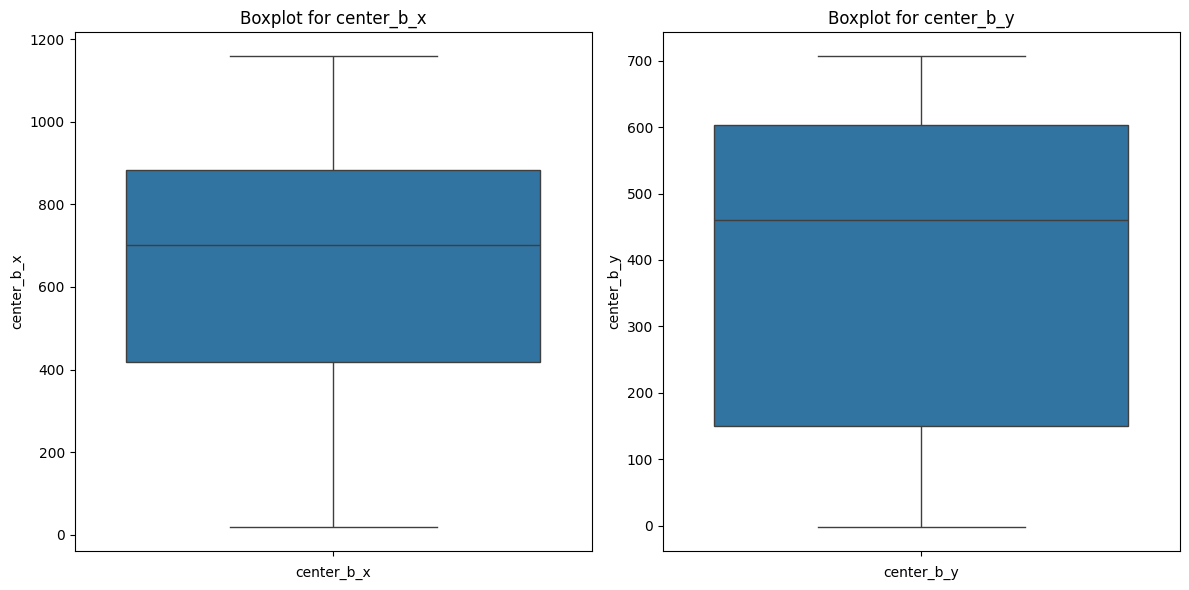


Detailed quartile information for center_b_x:
Q1 (25th percentile): 418.20003509521484
Q2 (Median, 50th percentile): 702.5518188476562
Q3 (75th percentile): 883.9282379150391
Min: 19.00262260437012
Max: 1159.2900390625
Mean: 659.0590476242483
Standard Deviation: 222.7019708826411

Detailed quartile information for center_b_y:
Q1 (25th percentile): 151.02898025512695
Q2 (Median, 50th percentile): 459.5777282714844
Q3 (75th percentile): 602.4534301757812
Min: -1.6759052276611328
Max: 706.9898071289062
Mean: 389.1545685239074
Standard Deviation: 216.7115196782369


In [20]:
# Selecionar as colunas desejadas
cols_to_plot = ['center_b_x', 'center_b_y']

# Configurar o tamanho da figura
plt.figure(figsize=(12, 6))

# Loop através das colunas selecionadas e plotar um boxplot para cada uma
for i, column in enumerate(cols_to_plot, 1):
  plt.subplot(1, 2, i)
  sns.boxplot(y=df_coords[column])
  plt.title(f'Boxplot for {column}')
  plt.xlabel(column)

# Ajustar layout para evitar sobreposição
plt.tight_layout()
plt.show()

# Calcular e mostrar os quartis para cada coluna
for column in cols_to_plot:
  quartiles = df_coords[column].describe(percentiles=[.25, .5, .75])
  print(f"\nDetailed quartile information for {column}:")
  print(f"Q1 (25th percentile): {quartiles['25%']}")
  print(f"Q2 (Median, 50th percentile): {quartiles['50%']}")
  print(f"Q3 (75th percentile): {quartiles['75%']}")
  print(f"Min: {quartiles['min']}")
  print(f"Max: {quartiles['max']}")
  print(f"Mean: {quartiles['mean']}")
  print(f"Standard Deviation: {quartiles['std']}")

# Formação dos quadrantes e areas:

In [21]:
# Coordenadas do quadrado maior (ajuste conforme necessário)
outer_coords_original = [(320, 50), (320, 680), (970, 680), (970, 50)]
min_x = 320
min_y = 50

## Visualização previa da aplicação no campo:

In [22]:
for idx, imagem in enumerate(primeiros_frames):
  num_linhas = 10
  num_colunas = 10
  altura, largura = imagem.shape[:2]
  altura_celula = altura / num_linhas
  largura_celula = largura / num_colunas

  fig, ax = plt.subplots()
  ax.imshow(imagem)

  # Copiar as coordenadas do quadrado maior para manipulação
  outer_coords = outer_coords_original.copy()

  # Calcular as coordenadas do quadrado menor, centro e pontos médios dos segmentos laterais
  center, mid_points, inner_coords = calculate_inner_square_and_more(outer_coords, scale=0.5)

  # Plotar quadrado maior
  outer_coords.append(outer_coords[0])  # Fechar o quadrado
  outer_coords = np.array(outer_coords)
  ax.plot(outer_coords[:, 0], outer_coords[:, 1], label='Outer Square')

  # Plotar quadrado menor
  inner_coords.append(inner_coords[0])  # Fechar o quadrado
  inner_coords = np.array(inner_coords)
  ax.plot(inner_coords[:, 0], inner_coords[:, 1], label='Inner Square')

  # Plotar pontos médios
  mid_points = np.array(mid_points)
  ax.scatter(mid_points[:, 0], mid_points[:, 1], color='red', label='Mid Points')

  # Plotar centro
  ax.scatter(center[0], center[1], color='green', label='Center', zorder=5)

  # Adicionar diagonais do quadrado maior
  for i in range(4):
    ax.plot([outer_coords[i, 0], outer_coords[(i + 2) % 4, 0]],
            [outer_coords[i, 1], outer_coords[(i + 2) % 4, 1]],
            color='purple', linestyle='dashed', label='Diagonals' if i == 0 else "")

  # Adicionar linhas horizontais e verticais conectando os pontos médios
  for i in range(4):
    for j in range(i + 1, 4):
      # Conectar horizontalmente se as coordenadas Y forem iguais
      if mid_points[i][1] == mid_points[j][1]:
        ax.plot([mid_points[i][0], mid_points[j][0]],
                [mid_points[i][1], mid_points[j][1]],
                color='orange', linestyle='dotted', label='Horizontal Lines' if i == 0 else "")

      # Conectar verticalmente se as coordenadas X forem iguais
      if mid_points[i][0] == mid_points[j][0]:
        ax.plot([mid_points[i][0], mid_points[j][0]],
                [mid_points[i][1], mid_points[j][1]],
                color='orange', linestyle='dotted', label='Vertical Lines' if i == 0 else "")

  # Adicionar título e labels
  ax.set_title(f'Squares and Points - Frame {idx}')
  ax.set_xlabel('X coordinate')
  ax.set_ylabel('Y coordinate')

  plt.grid(True)

  # Mostrar gráfico
  plt.show()

## Foco no movimento do rato - Uso de uma "normalização"

In [23]:
print(f"Coordenadas do quadrado erteno da caixa: \n{outer_coords}")

print(f"\nCoordenadas do quadrado irterno da caixa:\n{inner_coords}")

print(f"\nCoordenadas do meio das laterais da caixa: \n{mid_points}")

print(f"\nCoordenadas do centro da caixa: \n{center}")

Coordenadas do quadrado erteno da caixa: 
[[320  50]
 [320 680]
 [970 680]
 [970  50]
 [320  50]]

Coordenadas do quadrado irterno da caixa:
[[482.5 207.5]
 [482.5 522.5]
 [807.5 522.5]
 [807.5 207.5]
 [482.5 207.5]]

Coordenadas do meio das laterais da caixa: 
[[320. 365.]
 [645. 680.]
 [970. 365.]
 [645.  50.]]

Coordenadas do centro da caixa: 
[645.0, 365.0]


In [24]:
df_coords = normalizar_coluna(df_coords, 'center_b_x', min_x)
df_coords = normalizar_coluna(df_coords, 'center_b_y', min_y)
df_coords

,frame,id_amostra,rat,experimental_context,day,center_b_x,center_b_y,center_b_likelihood,center_b_x_normalizada,center_b_y_normalizada
0,0,CCM247-TR-Contexto2,CCM247,2,4,886.874023,96.242256,0.990015,566.874023,46.242256
1,1,CCM247-TR-Contexto2,CCM247,2,4,887.161743,96.214500,0.990392,567.161743,46.214500
2,2,CCM247-TR-Contexto2,CCM247,2,4,887.154846,96.205910,0.990359,567.154846,46.205910
3,3,CCM247-TR-Contexto2,CCM247,2,4,887.154846,96.205910,0.990359,567.154846,46.205910
4,4,CCM247-TR-Contexto2,CCM247,2,4,887.154846,96.205910,0.990359,567.154846,46.205910
...,...,...,...,...,...,...,...,...,...,...
1197015,17997,CCM271-HAB2-Contexto1,CCM271,1,2,403.220032,643.497559,0.960405,83.220032,593.497559
1197016,17998,CCM271-HAB2-Contexto1,CCM271,1,2,404.952240,643.319763,0.960552,84.952240,593.319763
1197017,17999,CCM271-HAB2-Contexto1,CCM271,1,2,404.614166,641.280334,0.955707,84.614166,591.280334
1197018,18000,CCM271-HAB2-Contexto1,CCM271,1,2,404.647156,641.285034,0.944732,84.647156,591.285034


## Trejatoria focada:

In [25]:
# Itera sobre as combinações únicas de id e day
combinacoes_unicas = df_coords[['id_amostra', 'rat', 'day', "experimental_context"]].drop_duplicates().sort_values(by=['rat', 'day'])
combinacoes_unicas

,id_amostra,rat,day,experimental_context
278959,CCM247-HAB-Contexto2,CCM247,1,2
314962,CCM247-HAB2-Contexto2,CCM247,2,2
296960,CCM247-HAB3-Contexto2,CCM247,3,2
0,CCM247-TR-Contexto2,CCM247,4,2
37807,CCM247-TT-Contexto2,CCM247,5,2
...,...,...,...,...
1107014,CCM273-HAB-Contexto2,CCM273,1,2
1071013,CCM273-HAB2-Contexto2,CCM273,2,2
1089014,CCM273-HAB3-Contexto2,CCM273,3,2
31958,CCM273-TR-Contexto2,CCM273,4,2


In [26]:
for _, row in combinacoes_unicas.iterrows():

    try:
      imagem = cv2.imread(f'{directory}/primeiro_frame/{row["id_amostra"]}.jpg')
      if imagem is None:
          raise ValueError("Erro ao carregar a imagem")
    except Exception as e:
      print(f"Erro ao carregar a imagem {row['id_amostra']}: {e}")
      continue

    imagem = cv2.imread(f'{directory}/primeiro_frame/{row["id_amostra"]}.jpg')
    print(row["rat"])

    altura, largura = imagem.shape[:2]

    altura_celula = altura - min_y
    largura_celula = largura - (min_x * 2)

    fig, ax = plt.subplots(figsize=(largura_celula/100, altura_celula/100))  # Configura o tamanho da figura em polegadas
    ax.set_xlim([0, largura_celula])
    ax.set_ylim([altura_celula, 0])  # Inverte o eixo y para manter a origem no canto superior esquerdo

    id_animal = row['rat']
    day = row['day']

    # Filtra o DataFrame para a combinação atual de id e day
    df_id_day = df_coords[(df_coords['rat'] == id_animal) & (df_coords['day'] == day)]

    if df_id_day.empty:
        continue

    # Adicionar grid
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)

    ax.plot(df_id_day['center_b_x_normalizada'], df_id_day['center_b_y'], marker='o', markersize=3, label=f'ID: {id_animal}, Day: {day}')

    # Adicionar rótulos e título
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('Trajetória das Amostras')
    ax.legend()

    # Mostrar o plot
    plt.show()

In [ ]:
from matplotlib.colors import LogNorm

for _, row in combinacoes_unicas.iterrows():
    try:
        imagem = cv2.imread(f'{directory}/primeiro_frame/{row["id_amostra"]}.jpg')
        if imagem is None:
            raise ValueError("Erro ao carregar a imagem")
    except Exception as e:
        print(f"Erro ao carregar a imagem {row['id_amostra']}: {e}")
        continue

    altura, largura = imagem.shape[:2]

    altura_celula = altura - min_y
    largura_celula = largura - (min_x * 2)

    fig, ax = plt.subplots(figsize=(largura_celula / 100, altura_celula / 100))  # Configura o tamanho da figura em polegadas
    ax.set_xlim([0, largura_celula])
    ax.set_ylim([altura_celula, 0])  # Inverte o eixo y para manter a origem no canto superior esquerdo

    id_animal = row['rat']
    day = row['day']

    # Filtra o DataFrame para a combinação atual de id e day
    df_id_day = df_coords[(df_coords['rat'] == id_animal) & (df_coords['day'] == day)]

    if df_id_day.empty:
        continue

    # Adicionar grid
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)

    # Criar o mapa de calor com hist2d
    # Ajustar gridsize e usar LogNorm para normalização
    hb = ax.hexbin(df_id_day['center_b_x_normalizada'], df_id_day['center_b_y'], gridsize=50, cmap='viridis', norm=LogNorm())

    # Adicionar a barra de cor
    cb = plt.colorbar(hb, ax=ax)
    cb.set_label('Densidade')

    # Adicionar rótulos e título
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title(f'Mapa de Calor - ID: {id_animal}, Day: {day}')

    # Mostrar o plot
    plt.show()

In [ ]:
for _, row in combinacoes_unicas.iterrows():
    try:
        imagem = cv2.imread(f'{directory}/primeiro_frame/{row["id_amostra"]}.jpg')
        if imagem is None:
            raise ValueError("Erro ao carregar a imagem")
    except Exception as e:
        print(f"Erro ao carregar a imagem {row['id_amostra']}: {e}")
        continue

    altura, largura = imagem.shape[:2]

    altura_celula = altura - min_y
    largura_celula = largura - (min_x * 2)

    # Configura o tamanho da figura em polegadas
    fig, ax = plt.subplots(figsize=(largura_celula / 100, altura_celula / 100))
    ax.set_xlim([0, largura_celula])
    ax.set_ylim([altura_celula, 0])  # Inverte o eixo y para manter a origem no canto superior esquerdo

    # Define a cor de fundo da figura e do eixo como preto
    fig.patch.set_facecolor('black')
    ax.set_facecolor('black')

    id_animal = row['rat']
    day = row['day']

    # Filtra o DataFrame para a combinação atual de id e day
    df_id_day = df_coords[(df_coords['rat'] == id_animal) & (df_coords['day'] == day)]

    if df_id_day.empty:
        continue

    # Adicionar grid com cor branca
    ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='white')

    # Criar o mapa de calor com hist2d
    # Ajustar gridsize e usar LogNorm para normalização
    hb = ax.hexbin(df_id_day['center_b_x_normalizada'], df_id_day['center_b_y'], gridsize=50, cmap='viridis', norm=LogNorm())

    # Adicionar a barra de cor
    cb = plt.colorbar(hb, ax=ax)
    cb.set_label('Densidade', color='white')

    # Adicionar rótulos e título com cor branca
    ax.set_xlabel('X', color='white')
    ax.set_ylabel('Y', color='white')
    ax.set_title(f'Mapa de Calor - ID: {id_animal}, Day: {day}', color='white')

    # Ajustar cor dos ticks dos eixos
    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')

    # Mostrar o plot
    plt.show()

# Produção de Tabelas de Inferência:

## Variáveis Importantes para todas as tabelas:

In [ ]:
area_externa = [
    {"Coord_X": 320, "Coord_Y": 50}, # Ponto quadrado externo superior esquerdo
    {"Coord_X": 320, "Coord_Y": 680}, # Ponto quadrado externo inferior esquerdo
    {"Coord_X": 970, "Coord_Y": 680}, # ponto quadrado externo inferior direito
    {"Coord_X": 970, "Coord_Y": 50} # ponto quadrado externo superior direito
]

area_interna = [
    {"Coord_X": 482.5, "Coord_Y": 207.5}, # Ponto quadrado interno superior esquerdo
    {"Coord_X": 482.5, "Coord_Y": 522.5}, # Ponto quadrado interno inferior esquerdo
    {"Coord_X": 807.5, "Coord_Y": 522.5}, # ponto quadrado interno inferior direito
    {"Coord_X": 807.5, "Coord_Y": 207.5} # ponto quadrado interno superior direito
]

linha_largura = 5

In [ ]:
regiao = "center_b"

area_externa = [320., 970., 50., 680.]
area_interna = [482.5, 807.5, 207.5, 522.5]

fps, altura, largura = 15, 720, 1280

## 1ª Tabela - Areas Interna e Externa

In [ ]:
result_df = objeto_dentro_do_campo(df_coords, regiao, area_externa, area_interna)
result_df

## 2ª Tabela - Quadrantes Euclidianos

### Modelo de visualização:

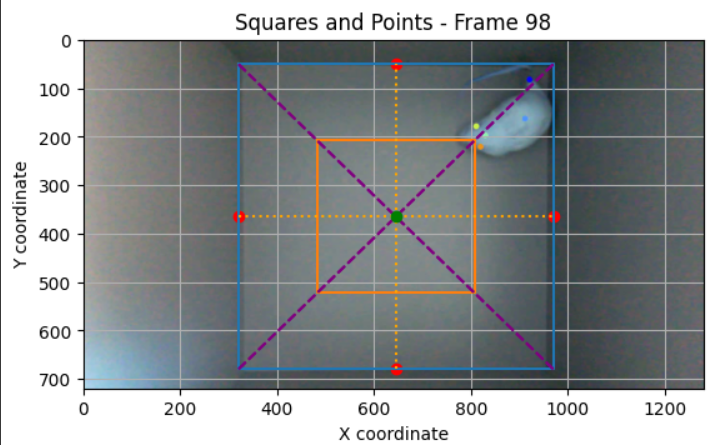

### Variáveis importantes para os quadrantes euclidianos:

In [ ]:
pontos_horizontais_verticais = [
    {"Coord_X": 320, "Coord_Y": 365}, # Ponto horizontal esquerdo
    {"Coord_X": 645, "Coord_Y": 680}, # Ponto vertical inferior
    {"Coord_X": 970, "Coord_Y": 365}, # ponto horizontal direito
    {"Coord_X": 645, "Coord_Y": 50} # ponto vertical superior
]

eixo_horizontal = [320, 365, 970, 365]
eixo_vertical = [645, 680, 645, 50]

### Tabela indicando o quadrante atual:

In [ ]:
# Agrupar o DataFrame por 'rat' e 'day'
grouped_df = result_df.groupby(['rat', 'day'])

quadrante_euclidiano = []

# Iterar sobre cada grupo de indivíduo singular
for name, animal in grouped_df:
  quadrantes = determinar_quadrante_euclidiano(animal, regiao, area_externa, eixo_horizontal, eixo_vertical)
  animal['quadrante_euclidiano'] = quadrantes
  quadrante_euclidiano.append(animal)

# Concatenar os resultados em um único DataFrame
result_df = pd.concat(quadrante_euclidiano)
result_df

In [ ]:
# # Filtra o DataFrame para incluir apenas as linhas onde quadrante_euclidiano == 1
# result_quadrante = result_df[(result_df['quadrante_euclidiano'] == 4) & (result_df['rat'] == "CCM247")]

# # Itera sobre as combinações únicas de id e day
# combinacoes_unicas = result_quadrante[['id_amostra', 'rat', 'day']].drop_duplicates().sort_values(by=['rat', 'day'])

# for _, row in combinacoes_unicas.iterrows():
#     try:
#         # Carregar a imagem
#         imagem = cv2.imread(f'{directory}/primeiro_frame/{row["id_amostra"]}.jpg')
#         if imagem is None:
#             raise ValueError("Erro ao carregar a imagem")
#     except Exception as e:
#         print(f"Erro ao carregar a imagem {row['id_amostra']}: {e}")
#         continue

#     altura, largura = imagem.shape[:2]

#     altura_celula = altura - min_y
#     largura_celula = largura - (min_x * 2)

#     fig, ax = plt.subplots(figsize=(largura_celula / 100, altura_celula / 100))  # Configura o tamanho da figura em polegadas
#     ax.set_xlim([0, largura_celula])
#     ax.set_ylim([altura_celula, 0])  # Inverte o eixo y para manter a origem no canto superior esquerdo

#     id_animal = row['rat']
#     day = row['day']

#     # Filtra o DataFrame para a combinação atual de id e day
#     df_id_day = result_quadrante[(result_quadrante['rat'] == id_animal) & (result_quadrante['day'] == day)]

#     if df_id_day.empty:
#         continue

#     # Adicionar grid
#     ax.grid(True, which='both', linestyle='--', linewidth=0.5)

#     # Plotar as coordenadas filtradas
#     ax.plot(df_id_day['center_b_x_normalizada'], df_id_day['center_b_y'], marker='o', markersize=3, label=f'ID: {id_animal}, Day: {day}')

#     # Adicionar rótulos e título
#     ax.set_xlabel('X')
#     ax.set_ylabel('Y')
#     ax.set_title('Trajetória das Amostras no Quadrante 1')
#     ax.legend()

#     # Mostrar o plot
#     plt.show()

### Tempo em cada quadrante:

In [ ]:
def contar_quadrantes(df, fps=15):
    """
    Conta quantas vezes cada indivíduo (definido por 'rat' e 'day') ficou em cada quadrante,
    considerando um determinado FPS, e adiciona colunas para áreas combinadas e tempo total.

    Parâmetros:
    df (pd.DataFrame): DataFrame contendo as colunas 'rat', 'day' e 'quadrante_euclidiano'.
    fps (int): Frames por segundo para converter a contagem de frames em tempo.

    Retorna:
    pd.DataFrame: DataFrame com a contagem de tempo (em segundos) em cada quadrante para cada indivíduo,
                  incluindo colunas adicionais para áreas combinadas e tempo total.
    """
    # Agrupar por 'rat', 'day' e 'quadrante_euclidiano' e contar as ocorrências
    contagem_quadrantes = df.groupby(['rat', 'day', 'quadrante_euclidiano']).size().reset_index(name='contagem')

    # Converter a contagem de frames em tempo (segundos)
    contagem_quadrantes['tempo_segundos'] = contagem_quadrantes['contagem'] / fps

    # Pivotar a tabela para obter uma visualização mais amigável
    tabela_pivot = contagem_quadrantes.pivot_table(index=['rat', 'day'], columns='quadrante_euclidiano', values='tempo_segundos', fill_value=0)

    # Resetar o índice para transformar 'rat' e 'day' em colunas normais
    tabela_pivot = tabela_pivot.reset_index()

    # Renomear colunas para os quadrantes
    tabela_pivot.columns = ['rat', 'day', 'Quadrante 1', 'Quadrante 2', 'Quadrante 3', 'Quadrante 4']

    # Adicionar colunas para áreas combinadas e tempo total
    tabela_pivot['area_superior'] = tabela_pivot.get('Quadrante 1', 0) + tabela_pivot.get('Quadrante 2', 0)
    tabela_pivot['area_inferior'] = tabela_pivot.get('Quadrante 3', 0) + tabela_pivot.get('Quadrante 4', 0)
    tabela_pivot['area_direita'] = tabela_pivot.get('Quadrante 2', 0) + tabela_pivot.get('Quadrante 3', 0)
    tabela_pivot['area_esquerda'] = tabela_pivot.get('Quadrante 1', 0) + tabela_pivot.get('Quadrante 4', 0)
    tabela_pivot['tempo_total_registrado(s)'] = tabela_pivot[['Quadrante 1', 'Quadrante 2', 'Quadrante 3', 'Quadrante 4']].sum(axis=1)

    # Adicionar coluna para tempo total registrado em minutos
    tabela_pivot['tempo_total_registrado(m)'] = tabela_pivot['tempo_total_registrado(s)'] / 60

    return tabela_pivot

In [ ]:
# Chamar a função para contar os quadrantes e calcular as áreas combinadas e o tempo total
tabela_quadrantes = contar_quadrantes(result_df, fps)

tabela_quadrantes

## 2.5 adição na tabela do tempo de cada quadrante - Duração area interna e externa

In [ ]:
# Calculando o tempo em cada posição
tempo_posicoes = result_df.groupby(['rat', 'day', 'experimental_context', 'posicao']).size().unstack(fill_value=0) / fps

# Renomeando as colunas para refletir as áreas
tempo_posicoes.columns = ['tempo_fora_caixa (s)', 'tempo_area_externa (s)', 'tempo_area_interna (s)']

# Resetando o índice para combinar com a tabela_quadrantes
tempo_posicoes = tempo_posicoes.reset_index()

tempo_posicoes

In [ ]:
# Garantindo que a tabela_quadrantes tenha as colunas 'rat' e 'day' como índices para combinar com tempo_posicoes
tabela_quadrantes.set_index(['rat', 'day'], inplace=True)

# Adicionando as colunas de tempo à tabela_quadrantes
tabela_quadrantes = tabela_quadrantes.join(tempo_posicoes.set_index(['rat', 'day']))

# Resetando o índice para a exibição final
tabela_quadrantes.reset_index(inplace=True)

# Reordenando as colunas
colunas = list(tabela_quadrantes.columns)
# Colocando as três últimas colunas antes da terceira coluna
novas_colunas = colunas[:2] + colunas[-4:] + colunas[2:-4]
tabela_quadrantes = tabela_quadrantes[novas_colunas]

tabela_quadrantes

## 3ª Tabela - Tempo em cada Parede:

### Modelo de visualização:

In [ ]:
import matplotlib.patches as patches

# Definição das áreas externas e internas
area_externa = [
    (320, 50),  # Ponto quadrado externo superior esquerdo
    (320, 680),  # Ponto quadrado externo inferior esquerdo
    (970, 680),  # ponto quadrado externo inferior direito
    (970, 50)  # ponto quadrado externo superior direito
]

area_interna = [
    (482.5, 207.5),  # Ponto quadrado interno superior esquerdo
    (482.5, 522.5),  # Ponto quadrado interno inferior esquerdo
    (807.5, 522.5),  # ponto quadrado interno inferior direito
    (807.5, 207.5)  # ponto quadrado interno superior direito
]

# Parede esquerdas
parede_esquerda = [(320, 50), (482.5, 50), (482.5, 680), (320, 680)]
# Parede inferior
parede_superior = [(320, 207.5), (970, 207.5), (970, 50), (320, 50)]
# Parede direita
parede_direita = [(807.5, 50), (970, 50), (970, 680), (807.5, 680)]
# Parede superior
parede_inferior = [(320, 680), (970, 680), (970, 522.5), (320, 522.5)]

fig, ax = plt.subplots()

# Desenha a área externa
ext = patches.Polygon(area_externa, closed=True, fill=None, edgecolor='r', label='Área Externa')
ax.add_patch(ext)

# Desenha a área interna
intn = patches.Polygon(area_interna, closed=True, fill=None, edgecolor='b', label='Área Interna')
ax.add_patch(intn)

# Desenha as paredes
parede_e = patches.Polygon(parede_esquerda, closed=True, fill=True, edgecolor='g', alpha=0.3, label='Parede Esquerda')
ax.add_patch(parede_e)

parede_i = patches.Polygon(parede_inferior, closed=True, fill=True, edgecolor='y', alpha=0.3, label='Parede Inferior')
ax.add_patch(parede_i)

parede_d = patches.Polygon(parede_direita, closed=True, fill=True, edgecolor='c', alpha=0.3, label='Parede Direita')
ax.add_patch(parede_d)

parede_s = patches.Polygon(parede_superior, closed=True, fill=True, edgecolor='m', alpha=0.3, label='Parede Superior')
ax.add_patch(parede_s)

# Configurações do gráfico
ax.set_xlim(300, 1000)
ax.set_ylim(30, 700)
ax.set_aspect('equal')
ax.legend()
plt.gca().invert_yaxis()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Definição das Áreas da Arena')
plt.show()

### Variáveis importantes para demarcação da parede

In [ ]:
# Função para determinar a área da parede
def determinar_area_parede(x, y, parede_esquerda, parede_inferior, parede_direita, parede_superior):
    if parede_esquerda["x_min"] <= x <= parede_esquerda["x_max"] and parede_esquerda["y_min"] <= y <= parede_esquerda["y_max"]:
        return "parede_esquerda"
    elif parede_inferior["x_min"] <= x <= parede_inferior["x_max"] and parede_inferior["y_min"] <= y <= parede_inferior["y_max"]:
        return "parede_inferior"
    elif parede_direita["x_min"] <= x <= parede_direita["x_max"] and parede_direita["y_min"] <= y <= parede_direita["y_max"]:
        return "parede_direita"
    elif parede_superior["x_min"] <= x <= parede_superior["x_max"] and parede_superior["y_min"] <= y <= parede_superior["y_max"]:
        return "parede_superior"
    else:
        return "fora_da_parede"

In [ ]:
# Definindo as coordenadas das áreas das paredes
parede_esquerda = {"x_min": 320, "x_max": 482.5, "y_min": 50, "y_max": 680}
parede_inferior = {"x_min": 320, "x_max": 970, "y_min": 522.5, "y_max": 680}
parede_direita = {"x_min": 807.5, "x_max": 970, "y_min": 50, "y_max": 680}
parede_superior = {"x_min": 320, "x_max": 970, "y_min": 50, "y_max": 207.5}

In [ ]:
# Adicionando a coluna 'area_parede' ao DataFrame
result_df['area_parede'] = result_df.apply(lambda row: determinar_area_parede(
    row['center_b_x'], row['center_b_y'],
    parede_esquerda, parede_inferior, parede_direita, parede_superior
), axis=1)

result_df

In [ ]:
frame_duration = 1 / fps  # Duração de cada frame em segundos

# Criar um DataFrame vazio para armazenar os tempos em cada área de parede
tempo_paredes = pd.DataFrame(columns=['rat', 'day', 'parede_esquerda (s)', 'parede_inferior (s)', 'parede_direita (s)', 'parede_superior (s)', 'fora_da_parede (s)'])

# Criar uma lista para armazenar os tempos em cada área de parede
lista_tempos_paredes = []

# Obter as combinações únicas de rat e day
combinacoes_unicas = result_df[['rat', 'day']].drop_duplicates()

# Iterar sobre cada combinação única de rat e day
for _, row in combinacoes_unicas.iterrows():
    rat = row['rat']
    day = row['day']

    # Filtrar o DataFrame para a combinação atual de rat e day
    df_filtered = result_df[(result_df['rat'] == rat) & (result_df['day'] == day)]

    # Calcular o tempo gasto em cada área de parede
    tempo_parede_esquerda = (df_filtered['area_parede'] == "parede_esquerda").sum() * frame_duration
    tempo_parede_inferior = (df_filtered['area_parede'] == "parede_inferior").sum() * frame_duration
    tempo_parede_direita = (df_filtered['area_parede'] == "parede_direita").sum() * frame_duration
    tempo_parede_superior = (df_filtered['area_parede'] == "parede_superior").sum() * frame_duration
    tempo_fora_da_parede = (df_filtered['area_parede'] == "fora_da_parede").sum() * frame_duration

    # Adicionar os tempos calculados à lista
    lista_tempos_paredes.append({
        'rat': rat,
        'day': day,
        'parede_esquerda (s)': tempo_parede_esquerda,
        'parede_inferior (s)': tempo_parede_inferior,
        'parede_direita (s)': tempo_parede_direita,
        'parede_superior (s)': tempo_parede_superior,
        'fora_da_parede (s)': tempo_fora_da_parede
    })

# Converter a lista em um DataFrame
tempo_paredes = pd.DataFrame(lista_tempos_paredes)

# Garantir que a tabela_quadrantes tenha as colunas 'rat' e 'day' como índices para combinar com tempo_posicoes
tabela_quadrantes.set_index(['rat', 'day'], inplace=True)

# Adicionar as colunas de tempo à tabela_quadrantes
tabela_quadrantes = tabela_quadrantes.join(tempo_paredes.set_index(['rat', 'day']))

# Resetar o índice para exibição final
tabela_quadrantes.reset_index(inplace=True)

# Reordenar as colunas para colocar as novas colunas de tempo na posição desejada
colunas = tabela_quadrantes.columns.tolist()
colunas_reordenadas = colunas[:6] + colunas[-5:] + colunas[6:-5]
tabela_quadrantes = tabela_quadrantes[colunas_reordenadas]

tabela_quadrantes

In [ ]:
tabela_quadrantes.info()

## 4ª Tabela - Tempo em cada Objeto:

In [ ]:
df_objetos = tabela_quadrantes[tabela_quadrantes["day"] > 3].reset_index(drop=True)
df_objetos

In [ ]:
df_antares = pd.read_csv(directory + '/result_antares/results/all_data.csv')
df_antares

In [ ]:
df_antares.info()

In [ ]:
# Criar a coluna 'day' baseada nos caracteres 7 e 8
def determinar_day(attribute):
    if attribute[7:9] == 'TR':
        return 4
    elif attribute[7:9] == 'TT':
        return 5
    elif attribute[7:9] == 'HA':
        return 1
    else:
        return None  # Caso não seja 'TR' ou 'TT', pode ajustar conforme necessário

In [ ]:
# Criar a coluna 'rat' com os 6 primeiros caracteres de 'attribute'
df_antares['rat'] = df_antares['attribute'].str[:6]

df_antares['day'] = df_antares['attribute'].apply(determinar_day)

df_antares

In [ ]:
# Pivotar o DataFrame
df_pivot = df_antares.pivot_table(index=['rat', 'day'], columns='object',
                                           values=['X', 'Y', 'Radius'], aggfunc='first')

df_pivot

In [ ]:
# Flatten the column multi-index
df_pivot.columns = [f'{val}_object_{col}' for val, col in df_pivot.columns]

# Reset the index to convert the multi-index back into columns
df_pivot.reset_index(inplace=True)

df_pivot

In [ ]:
# Criar a coluna 'rat' com os 6 primeiros caracteres de 'id_video'
dados_image['rat'] = dados_image['id_video'].str[:6]

dados_image['day'] = dados_image['id_video'].apply(determinar_day)

dados_video_orm = dados_image[dados_image["day"] > 1].reset_index(drop=True)
dados_video_orm

# Salvando os dados:

In [ ]:
tabela_quadrantes.to_csv(directory+'/result_artemis/tempos_quadrantes.csv', index=False)
tabela_quadrantes.to_excel(directory + '/result_artemis/tempos_quadrantes.xlsx', index=False)